<center> <h1>Evidence on returns to active strategies</h1> </center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Emory_small.png" height="200px" width="300px" />
</center>                                                                                            

## Backtesting an investment strategy

Make sure to use information that was actually available in real time.

Could motivate by imagining buying stocks based on *next* quarter's market capitalization.

## Investment styles: Size, value, and momentum

A “style” is a simple characteristic of an investment,
that is used to form broad portfolios to (hopefully) beat the market.

In the stock market, the best-known styles are:
- Size: Another name for market capitalization.
- Value: A valuation ratio involving the stock price.
- Momentum: The stock’s return over recent months.

Today we will look at average returns based on these styles,
using evidence from the US stock market from 1926 to the present.

(Later in the course we will use “factor” as another name for “style”.)

## Backtesting a style-based investment strategy

1. Give a precise definition of the style you are studying. Examples:
    - **Size:** The market capitalization of the stock’s issuer.
    - **Value:** The issuer’s book-to-market ratio.
    - **Momentum:** The price increase from month t − 13 to t − 1.  

(Definitions vary in practice, but we will focus on those listed above.)

2. Backtest the performance of portfolios sorted on this basis:  
- At the start of each past year in your data, sort stocks into different portfolios based on the characteristic you are studying.
- Calculate each portfolio’s value-weighted return for that year.
- Repeat for each year in the data.

3. Compare each portfolio’s returns with the market.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import wrds
import math
import numpy
import statsmodels.formula.api
import wget, shutil
import os

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]

### Average returns across portfolios formed on size (market capitalization)

In [ ]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on market capitalization ("size")
try: os.remove('Portfolios_Formed_on_ME_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_ME.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_ME_CSV.zip','Portfolios_Formed_on_ME_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_ME_CSV.zip')

# Read the data from the CSV file
size_portfolios = pd.read_csv('Portfolios_Formed_on_ME.CSV',skiprows=2372,nrows=97)
size_portfolios.columns = ['year','negative','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
size_portfolios = size_portfolios[['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']].set_index('year')
size_portfolios = size_portfolios/100

In [2]:
# Build the textbook's figure 11.4. (End in 2021 for consistency with that figure.)
size_portfolios = size_portfolios.loc['1926':'2021']
size_portfolios_figure = plt.figure();
means = [100*size_portfolios['d'+str(n)].mean() for n in range(1,11)];
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("Market cap decile (1=small,10=large)");
plt.ylabel("Arithmetic average \n annual return (%)");

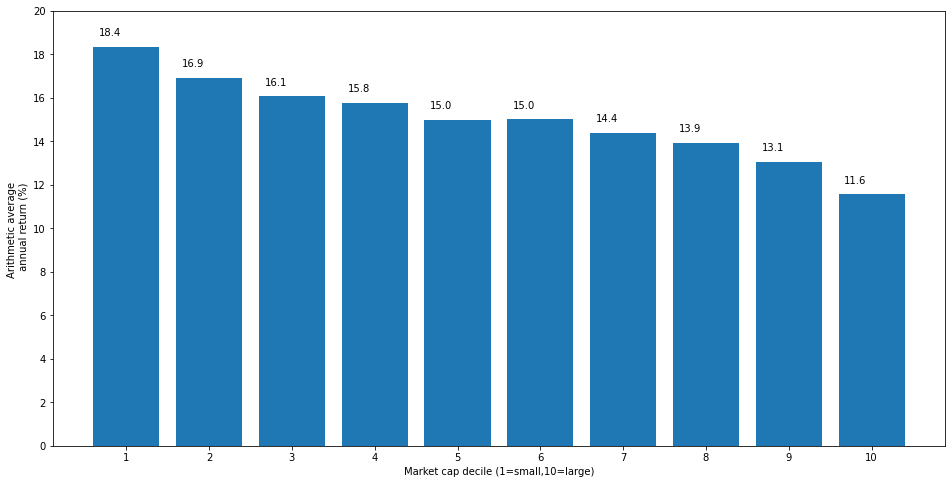

In [3]:
size_portfolios_figure

## Average returns across portfolios formed on value

In [4]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on book-to-market ratio ("value")
try: os.remove('Portfolios_Formed_on_BE-ME_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_BE-ME.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_BE-ME_CSV.zip','Portfolios_Formed_on_BE-ME_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_BE-ME_CSV.zip')

# Read the data from the CSV file and plot average annual returns across the portfolios, as we did for size above.
value_portfolios = pd.read_csv('Portfolios_Formed_on_BE-ME.CSV',skiprows=2383,nrows=97)
value_portfolios.columns = ['year','negative','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
value_portfolios = value_portfolios[['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']].set_index('year')
value_portfolios = value_portfolios/100

# Build the figure
value_portfolios = value_portfolios.loc['1926':'2021']
value_portfolios_figure = plt.figure()
means = [100*value_portfolios['d'+str(n)].mean() for n in range(1,11)]
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("B/M decile (1=low,10=high)")
plt.ylabel("Arithmetic average \n annual return (%)");

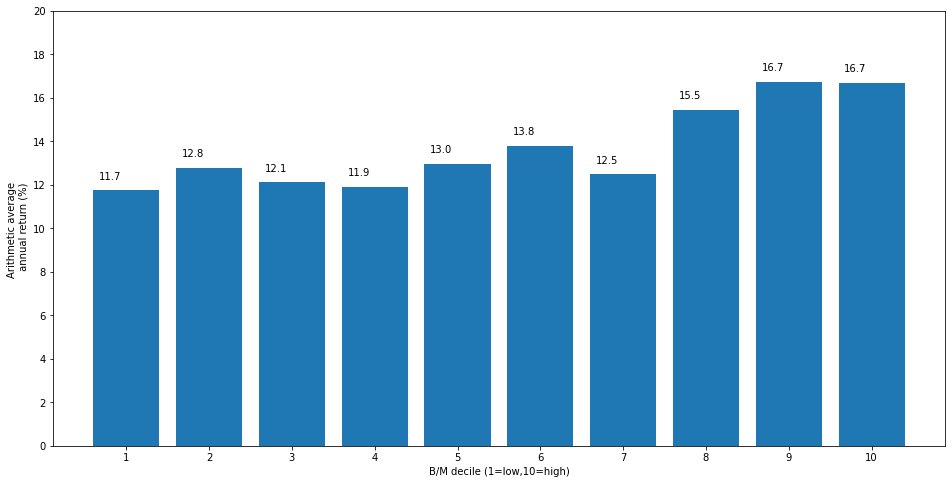

In [5]:
value_portfolios_figure

## Average returns across portfolios formed on momentum

In [6]:
%%capture

# Download Ken French's historical data on 10 portfolios formed on recent price increases ("momentum")
try: os.remove('10_Portfolios_Prior_12_2_CSV.zip')
except OSError: pass
try: os.remove('10_Portfolios_Prior_12_2.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Portfolios_Prior_12_2_CSV.zip','10_Portfolios_Prior_12_2_CSV.zip')
shutil.unpack_archive('10_Portfolios_Prior_12_2_CSV.zip')

# Read the data from the CSV file and plot average annual returns across the portfolios, as we did for size and value above.
mom_portfolios = pd.read_csv('10_Portfolios_Prior_12_2.CSV',skiprows=2358,nrows=97)
mom_portfolios.columns = ['year','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
mom_portfolios = mom_portfolios.set_index('year')
mom_portfolios = mom_portfolios/100
mom_portfolios = mom_portfolios.loc['1926':'2021']

# Build the figure
momentum_portfolios_figure = plt.figure()
means = [100*mom_portfolios['d'+str(n)].mean() for n in range(1,11)]
plt.bar(range(1,11),means);
plt.xticks(range(1,11),range(1,11));
plt.yticks([2*i for i in range(0,11)]);
for i in range(1,11):
    plt.text(i-0.33,means[i-1]+0.5,"%3.1f" % means[i-1]);
plt.xlabel("Momentum decile (1=low,10=large)");
plt.ylabel("Arithmetic average \n annual return (%)");

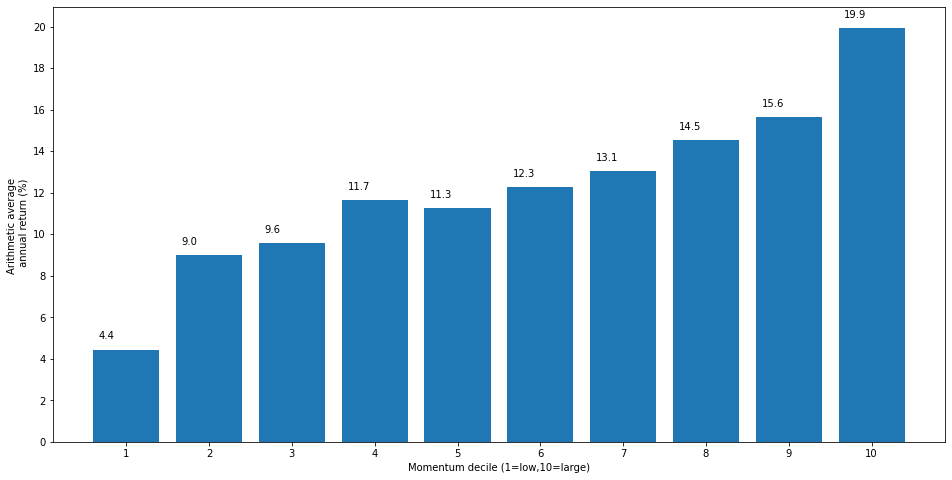

In [7]:
momentum_portfolios_figure

## What is missing from this evidence?

- Past performance does not guarantee future performance.
    - As we mentioned earlier, we can’t do much about this.

- Transaction costs may be quite large.
    - We will spend some time on this issue, but not much.
    - In general, it doesn’t change today’s conclusions: Style-based strategies have outperformed the market.

- **Risk**: We have only looked at long-run averages (90+ years).
    - For any one person, there is no guarantee what the average will be within their investment horizon, or what kind of short-term risk they might have to accept to pursue these strategies.
    - How should we measure risk? How much risk is too much? These questions are our main focus after Midterm 1.

## Comparison of average return and volatility across portfolios formed on size

In [8]:
%%capture
size_volatility_figure = plt.figure()
means = [100*size_portfolios['d'+str(n)].mean() for n in range(1,11)]
vols = [100*size_portfolios['d'+str(n)].std() for n in range(1,11)]
plt.scatter(vols,means);
for i in range(1,11):
    plt.text(vols[i-1]+0.3,means[i-1]-0.3,str(i));
plt.xlabel("Volatility of annual return");
plt.ylabel("Arithmetic average annual return");

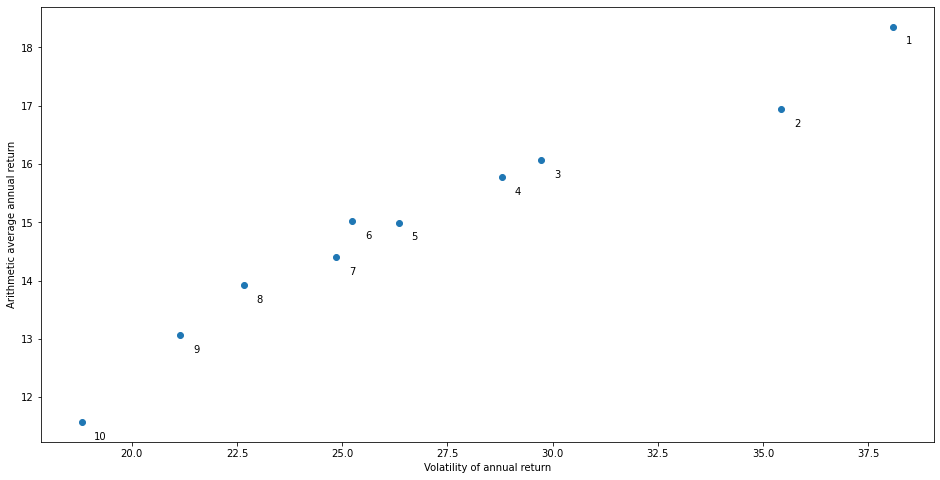

In [9]:
size_volatility_figure